# Problem Set 4: Clustering and Dimensionality Reduction

To run and solve this assignment, one must have a working IPython Notebook installation. The easiest way to set it up for both Windows and Linux is to install [Anaconda](https://www.anaconda.com/products/individual). Then save this file to your computer, run Anaconda and choose this file in Anaconda's file explorer. Use `Python 3` version. The statements below assume that you have already followed these instructions. If you are new to Python or its scientific library, Numpy, there are some nice tutorials [here](https://www.learnpython.org/) and [here](http://www.scipy-lectures.org/).

To run code in a cell or to render [Markdown](https://en.wikipedia.org/wiki/Markdown)+[LaTeX](https://en.wikipedia.org/wiki/LaTeX) press `Ctr+Enter` or `[>|]`(like "play") button above. To edit any code or text cell double click on its content. To change cell type, choose "Markdown" or "Code" in the drop-down menu above. Here are some useful resources for [Markdown guide](https://www.markdownguide.org/basic-syntax/) and [LaTeX tutorial](https://www.overleaf.com/learn/latex/Learn_LaTeX_in_30_minutes) if you are not familiar with the basic syntax.


### Submission Guidelines

You need to submit **the output of the notebook as PDF** and **an additional .py file** on Gradescope.

For the .py file, Here are the guidelines :

1. The .py file should contain ONLY your typed codes. (Do not include any other code apart from what you coded for the assignment)

2. .py should NOT contain any written answers. Only code written by you.

3. If your typed code falls under a function definition thats predefined by us, Only include your typed code and nothing else.

4. For each cell block within colab/jupyter that you typed your code in, Add 2 new lines ("\n") before pasting your typed code in the .py file.


 The assignment is graded on completion. You will also need to **answer** whether you attempted the question or not in Gradescope. It is extremely important that you complete all assignments (both the programming and written questions), as they will prepare you for quizzes and exams.

**Total: 160 points** (90 (Q1) + 70 (Q2)) plus **40 BONUS points**.

### 1. Clustering

The following exercises help you better understand clustering methods.
First, in exercises 1.1-5, you will implement the $K$-means algorithm.
You will practice on an toy 2D dataset that will help you gain an intuition of how the $K$-means algorithm works.

In exercises 1.6-7, you will derive the Mixture of Gaussians distribution and compare and contrast the $K$-means algorithm to the GMM algorithm.

Problem 1.8 is a BONUS question asking you to use the $K$-means algorithm for image compression by reducing the number of colors that occur in an image to
only those that are most common.

**1\.1 Implementing $K$-means**

The $K$-means algorithm is a method to automatically cluster similar
data examples together. Concretely, you are given a training set
$\{ x_1 ,
    \cdots , x_m\} \text{where } x_i \in \mathbb{R}^n$, and we want to
group the data into a few cohesive clusters. The intuition behind
$K$-means is an iterative procedure that starts by guessing the initial
centroids, and then refines this guess by repeatedly assigning examples
to their closest centroids and then recomputing the centroids based on
the assignments.

The inner loop of the algorithm repeatedly carries out two steps:

1.  Assigning each training example x to its closest centroid

2.  Recomputing the mean of each centroid using the points assigned to
    it

The $K$-means algorithm will always converge to some final set of means
for the centroids. Note that the converged solution may not always be
ideal and depends on the initial setting of the centroids. Therefore, in
practice the $K$-means algorithm is usually run a few times with
different random initializations. One way to choose between the
solutions from different random initializations is to choose the one
with the lowest cost function value (distortion). You will implement the
two phases of the $K$-means algorithm separately in the next sections.

**1.2 Visualizing the data**

Run the provided code below and take a look at the resulting plot to gain an understanding of the
distribution of the data. It is two dimensional, with $x_1$ and $x_2$. The "x" markers are the initial centroids of the clustering algorithm, where $K=3$.


In [1]:
from __future__ import absolute_import

import random

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import scipy.misc


def plot_data(samples, centroids, clusters=None):
    """
    Plot samples and color it according to cluster centroid.
    :param samples: samples that need to be plotted.
    :param centroids: cluster centroids.
    :param clusters: list of clusters corresponding to each sample.
    If clusters is None, all points are plotted with the same color.
    """

    colors = ['blue', 'green', 'gold']
    assert centroids is not None

    if clusters is not None:
        sub_samples = []
        for cluster_id in range(centroids[0].shape[0]):
            sub_samples.append(np.array([samples[i] for i in range(samples.shape[0]) if clusters[i] == cluster_id]))
    else:
        sub_samples = [samples]

    plt.figure(figsize=(7, 5))

    for cluster_id, clustered_samples in enumerate(sub_samples):
        plt.plot(clustered_samples[:, 0], clustered_samples[:, 1], 'o', color=colors[cluster_id], alpha=0.75,
                 label='Data Points: Cluster %d' % cluster_id)

    plt.xlabel('x1', fontsize=14)
    plt.ylabel('x2', fontsize=14)
    plt.title('Plot of X Points', fontsize=16)
    plt.grid(True)

    # Drawing a history of centroid movement, first centroid is black
    tempx, tempy = [], []
    for mycentroid in centroids:
        tempx.append(mycentroid[:, 0])
        tempy.append(mycentroid[:, 1])

    plt.plot(tempx, tempy, 'rx--', markersize=8)
    plt.plot(tempx[0], tempy[0], 'kx', markersize=8)

    plt.legend(loc=4, framealpha=0.5)
    plt.show(block=True)



(300, 2)


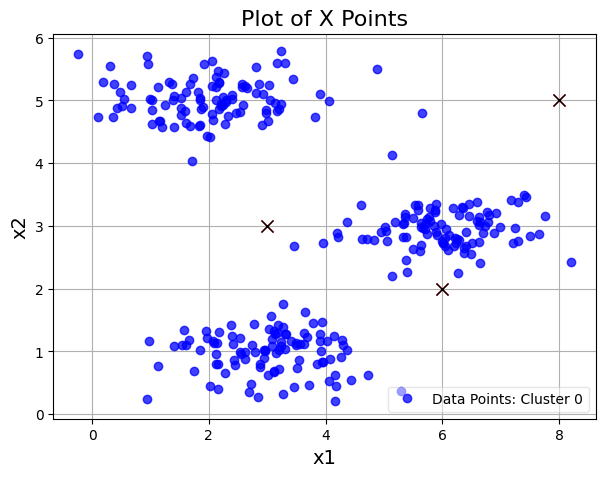

In [2]:
datafile = 'data/data2.mat'
mat = scipy.io.loadmat(datafile)
samples = mat['X']
# samples contain 300 pts, each has two coordinates
print(samples.shape)

# Choose the initial centroids
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
plot_data(samples, [initial_centroids])


**1.3 Finding closest centroids \[20 pts\]**

In the cluster assignment phase of the $K$-means algorithm, the
algorithm assigns every training example $x_i$ to its closest centroid,
given the current positions of centroids. Specifically, for every
example $i$ we set

$$c_i := \arg\min_j ||x_i - \mu_j||^2$$

where $c_i$ is the index of the centroid that is closest to $x_i$, and j
is the position (index) of the $j$-th centroid.

Your task is to complete the code in *find_closest_centroids*. This
function takes the data matrix samples and the locations of all
centroids and should output a one-dimensional array of clusters that
holds the index (a value in $\{1,\cdots,K\}$, where $K$ is total number
of clusters) of the closest centroid to every training example. You can
implement this using a loop over every training example and every
centroid.

Once you have completed the code in *find_closest_centroids*, run
it and you should see the output $[ 0, 2, 1]$ corresponding to the
centroid assignments for the first 3 examples.

In [7]:
print(samples)

print(samples[1])

[[ 1.84207953  4.6075716 ]
 [ 5.65858312  4.79996405]
 [ 6.35257892  3.2908545 ]
 [ 2.90401653  4.61220411]
 [ 3.23197916  4.93989405]
 [ 1.24792268  4.93267846]
 [ 1.97619886  4.43489674]
 [ 2.23454135  5.05547168]
 [ 2.98340757  4.84046406]
 [ 2.97970391  4.80671081]
 [ 2.11496411  5.37373587]
 [ 2.12169543  5.20854212]
 [ 1.5143529   4.77003303]
 [ 2.16979227  5.27435354]
 [ 0.41852373  4.88312522]
 [ 2.47053695  4.80418944]
 [ 4.06069132  4.99503862]
 [ 3.00708934  4.67897758]
 [ 0.66632346  4.87187949]
 [ 3.1621865   4.83658301]
 [ 0.51155258  4.91052923]
 [ 3.1342801   4.96178114]
 [ 2.04974595  5.6241395 ]
 [ 0.66582785  5.24399257]
 [ 1.01732013  4.84473647]
 [ 2.17893568  5.29758701]
 [ 2.85962615  5.26041997]
 [ 1.30882588  5.30158701]
 [ 0.99253246  5.01567424]
 [ 1.40372638  4.57527684]
 [ 2.66046572  5.19623848]
 [ 2.79995882  5.11526323]
 [ 2.06995345  4.6846713 ]
 [ 3.29765181  5.59205535]
 [ 1.8929766   4.89043209]
 [ 2.55983064  5.26397756]
 [ 1.15354031  4.67866717]
 

In [8]:
def find_closest_centroids(samples, centroids):
    """
    Find the closest centroid for all samples.

    :param samples: input data samples.
    :param centroids: an array of cluster centroids.
    :return: a list of cluster assignments (indices) for each sample.
    """
    clusters = np.zeros((samples.shape[0], 1))
    for sample_idx, sample in enumerate(samples):
        # reset distance between a sample point and a cluster to infinte positive number and closest cluster index to -1
        distance = float('inf')
        closest_cluster = -1
        
        # Retrieval each centroid and get the closester cluster index
        for cluster_index, centroid in enumerate(centroids):
            dist = np.linalg.norm(sample - centroid)
            
            if dist < distance:
                distance = dist
                closest_cluster = cluster_index
                
        clusters[sample_idx] = closest_cluster
        
    return clusters

[0. 2. 1.]


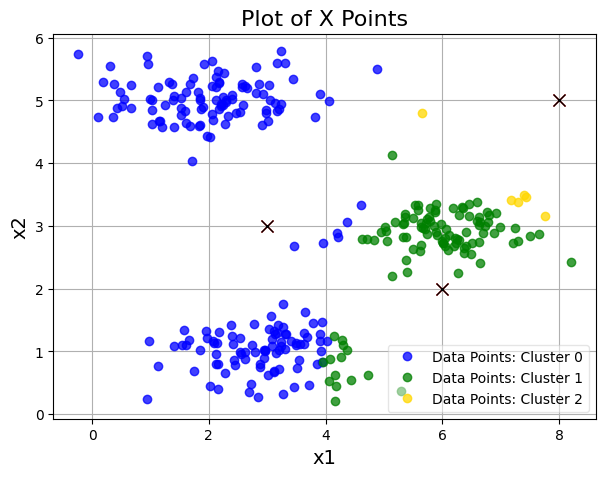

In [9]:
clusters = find_closest_centroids(samples, initial_centroids)
# you should see the output [0, 2, 1] corresponding to the
# centroid assignments for the first 3 examples.
print(clusters[:3].flatten())
plot_data(samples, [initial_centroids], clusters)

**1.4 Computing centroid means \[20 pts\]**

Given assignments of every point to a centroid, the second phase of the
algorithm recomputes, for each centroid, the mean of the points that
were assigned to it. Specifically, for every centroid $k$ we set

$$\mu_k := \frac{1}{|C_k|}\sum_{i\in C_k} x_i$$

where $C_k$ is the set of examples that are assigned to centroid $k$.
Concretely, if only two examples say $x_3$ and $x_5$ are assigned to centroid
$k
    = 2$, then you should update

$$\mu_2=\frac{1}{2}(x_3 + x_5).$$

Complete the code in *get_centroids* to do this.

In [ ]:
def get_centroids(samples, clusters):
    """
    Find the new centroid (mean) given the samples and their cluster.

    :param samples: samples.
    :param clusters: list of clusters corresponding to each sample.
    :return: an array of centroids.
    """
    raise NotImplementedError('Implement it yourself.')

Once you have completed it, *run_k_means* below will run your code and output the centroids after
the first step of $K$-means. The final centroids should be roughly \[\[
1.9 5.0\] \[ 3.0 1.0\] \[ 6.0 3.0\]\].

The code below will produce a visualization that plots the progress of the algorithm at each iteration. The red crosses show how each step of the $K$-means algorithm changes the centroids. You should also see the final cluster assignments as color-coded points.


In [ ]:
def run_k_means(samples, initial_centroids, n_iter):
    """
    Run K-means algorithm. The number of clusters 'K' is defined by the size of initial_centroids
    :param samples: samples.
    :param initial_centroids: a list of initial centroids.
    :param n_iter: number of iterations.
    :return: a pair of cluster assignment and history of centroids.
    """

    centroid_history = []
    current_centroids = initial_centroids
    clusters = []
    for iteration in range(n_iter):
        centroid_history.append(current_centroids)
        print("Iteration %d, Finding centroids for all samples..." % iteration)
        clusters = find_closest_centroids(samples, current_centroids)
        print("Recompute centroids...")
        current_centroids = get_centroids(samples, clusters)

    return clusters, centroid_history

Iteration 0, Finding centroids for all samples...
Recompute centroids...
Iteration 1, Finding centroids for all samples...
Recompute centroids...
Iteration 2, Finding centroids for all samples...
Recompute centroids...
Iteration 3, Finding centroids for all samples...
Recompute centroids...
Iteration 4, Finding centroids for all samples...
Recompute centroids...
Iteration 5, Finding centroids for all samples...
Recompute centroids...
Iteration 6, Finding centroids for all samples...
Recompute centroids...
Iteration 7, Finding centroids for all samples...
Recompute centroids...
Iteration 8, Finding centroids for all samples...
Recompute centroids...
Iteration 9, Finding centroids for all samples...
Recompute centroids...


<ipython-input-1-6dcd3fd0fbc4>:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  cluster_id = sub_samples.index(clustered_samples)
<ipython-input-1-6dcd3fd0fbc4>:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  cluster_id = sub_samples.index(clustered_samples)


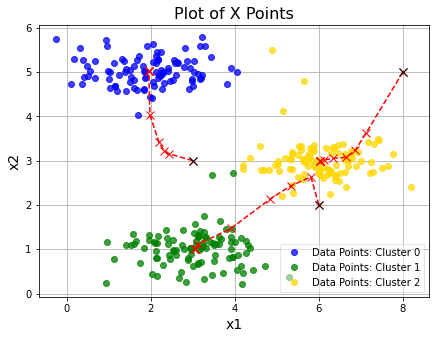

In [ ]:
# Run the full K-means algorithm and plot the results
clusters, centroid_history = run_k_means(samples, initial_centroids, n_iter=10)
plot_data(samples, centroid_history, clusters)

**1.5 Random initialization \[10 pts\]**

The initial assignments of centroids for the example dataset in the previous section were designed so that you could test your algorithm, i.e., if you implemented it correctly you would see the same output as we provided.  In practice, a good strategy for initializing the centroids is to select random examples from the training set.

In this part of the exercise, you should complete the function *choose_random_centroids*. You should randomly permute the indices of the examples using random seed 7. Then, select the first $K$ examples
based on the random permutation of the indices. This should allow the examples to be selected at random without the risk of selecting the same example twice. You will see how the random initialization affects the first few iterations of clustering, and also possibly, results in a
different cluster assignment.

In [ ]:
def choose_random_centroids(samples, K):
    """
    Randomly choose K centroids from samples.
    :param samples: samples.
    :param K: K as in K-means. Number of clusters.
    :return: an array of centroids.
    """
    raise NotImplementedError('Implement it yourself.')

Iteration 0, Finding centroids for all samples...
Recompute centroids...
Iteration 1, Finding centroids for all samples...
Recompute centroids...
Iteration 2, Finding centroids for all samples...
Recompute centroids...
Iteration 3, Finding centroids for all samples...
Recompute centroids...
Iteration 4, Finding centroids for all samples...
Recompute centroids...
Iteration 5, Finding centroids for all samples...
Recompute centroids...
Iteration 6, Finding centroids for all samples...
Recompute centroids...
Iteration 7, Finding centroids for all samples...
Recompute centroids...
Iteration 8, Finding centroids for all samples...
Recompute centroids...
Iteration 9, Finding centroids for all samples...
Recompute centroids...


<ipython-input-1-6dcd3fd0fbc4>:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  cluster_id = sub_samples.index(clustered_samples)
<ipython-input-1-6dcd3fd0fbc4>:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  cluster_id = sub_samples.index(clustered_samples)


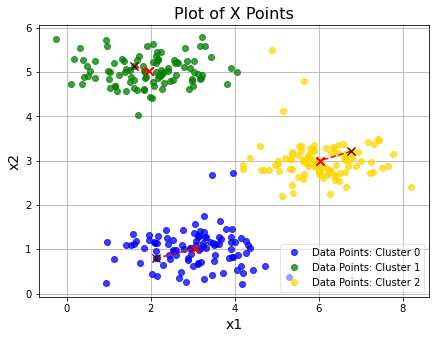

In [ ]:
# Let's choose random initial centroids and see the resulting
# centroid progression plot.. run it a few times, see if you can
# find a particularly bad case (no need to report it)
clusters, centroid_history = run_k_means(samples, choose_random_centroids(samples, K=3), n_iter=10)
plot_data(samples, centroid_history, clusters)


**1.6 Deriving Mixture of Gaussians \[20 pts\]**

(Problem 9.3 in Bishop.)

Consider a Gaussian mixture model in which the K-dimensional one-hot latent variable $z$ represents the component and has marginal distribution
$$ p(z) = \prod_{k=1}^K \pi_k^{z_k} $$  
and the conditional distribution $p(x|z)$ for the observed variable is given by
$$ \prod_{k=1}^K\mathcal{N}(x|\mu_k,\Sigma_k)^{z_k} $$
where $\mu_k, \Sigma_k$ are the parameters of the $k$th Gaussian distribution. Show that the marginal distribution $p(x)$ obtained by marginalizing over all possible values of $z$ is a Gaussian mixture of the form
$$\sum_{k=1}^K\pi_k\mathcal{N}(x|\mu_k, \Sigma_k)$$.



[[insert solution here]]

**1.7 K-means vs GMM \[20 pts\]**

(a) Compare and contrast the two methods.

(b) Describe in detail how you would modify the $K$-means algorithm to make it into a Gaussian mixture algorithm, and vice versa.

[[insert solution here]]

**1.8 [BONUS] Image compression with $K$-means \[20 pts\]**

In this OPTIONAL exercise, you will apply your implemented $K$-means algorithm to image compression.

In a 24-bit color representation of an image, each pixel is represented
as three 8-bit unsigned integers (ranging from 0 to 255) that specify
the red, green and blue intensity values. This is often referred to as
the RGB encoding. Our image contains thousands of colors, and in this
part of the exercise, you will reduce the number of colors to 16.

By making this reduction, it is possible to represent the photo in an
efficient way (compressed). Specifically, you only need to store the RGB
values of the 16 selected colors, and for each pixel in the image you
now need to only store the index of the color at that location (where
only 4 bits are necessary to represent 16 possibilities).

In this exercise, you will use the $K$-means algorithm to select the 16
colors that will be used to represent the compressed image. Concretely,
you will treat every pixel in the original image as a data example and
use the $K$-means algorithm to find the 16 colors that best group
(cluster) the pixels in the 3-dimensional RGB space. Once you have
computed the cluster centroids on the image, you will then use the 16
colors to replace the pixels in the original image.

The code below creates a three-dimensional matrix *bird_small* whose
first two indices identify a pixel position and whose last index
represents red, green, or blue. For example, *bird\_small(50, 33, 2)*
gives the blue intensity of the pixel at row 50 and column 33.


bird_small shape is  (128, 128, 3)


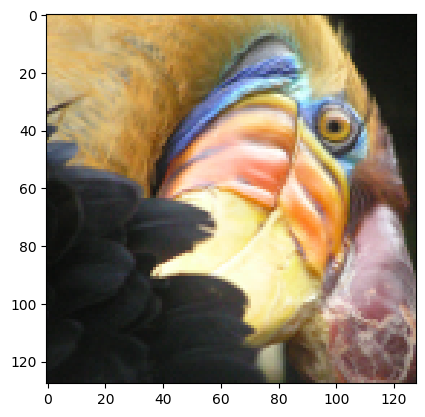

In [ ]:
from __future__ import absolute_import

import matplotlib.pyplot as plt
import numpy as np
import scipy
import imageio

datafile = 'data/bird_small.png'
# This creates a three-dimensional matrix bird_small whose first two indices
# identify a pixel position and whose last index represents red, green, or blue.
#bird_small = scipy.misc.imread(datafile)
bird_small = imageio.imread(datafile)

print("bird_small shape is ", bird_small.shape)
plt.imshow(bird_small)
plt.show()

Write code below to call your $K$-means function to cluster the pixels colors in the image into $K$ clusters.

After finding the top K = 16 colors to represent the image, assign each pixel position to its closest centroid using the findClosestCentroids function. This allows you to represent the original image using the centroid assignments of each pixel. Notice that you have significantly reduced the number of bits that are required to describe the image. The original image required 24 bits for each of the
$128 \times 128$ pixel locations, resulting in a total of $128 \times 128 \times 24 = 393,216$ bits.

The new representation requires some overhead storage in the form of a dictionary of 16 colors, each of which require 24 bits, but the image itself now only requires 4 bits per pixel location. The final number of bits used is therefore $16 \times 24 + 128 \times  128 \times  4 = 65,920$ bits, which corresponds to compressing the original image by about a factor of 6.

Finally, show the effect of the compression by reconstructing the image based only on the centroid assignments.

Iteration 0, Finding centroids for all samples...
Recompute centroids...
Iteration 1, Finding centroids for all samples...
Recompute centroids...
Iteration 2, Finding centroids for all samples...
Recompute centroids...
Iteration 3, Finding centroids for all samples...
Recompute centroids...
Iteration 4, Finding centroids for all samples...
Recompute centroids...
Iteration 5, Finding centroids for all samples...
Recompute centroids...
Iteration 6, Finding centroids for all samples...
Recompute centroids...
Iteration 7, Finding centroids for all samples...
Recompute centroids...
Iteration 8, Finding centroids for all samples...
Recompute centroids...
Iteration 9, Finding centroids for all samples...
Recompute centroids...


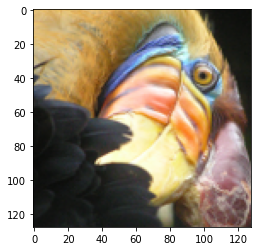

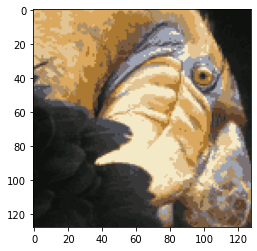

In [ ]:
# Divide every entry in bird_small by 255 so all values are in the range of 0 to 1
bird_small = bird_small / 255.

# Unroll the image to shape (16384,3) (16384 is 128*128)
bird_small = bird_small.reshape(-1, 3)

# Run k-means on this data, forming 16 clusters, with random initialization
raise NotImplementedError('Implement this part.')

# Now we have 16 centroids, each representing a color.
# Let's assign an index to each pixel in the original image dictating
# which of the 16 colors it should be. Use your find_closest_centroids
# function and store the result in "clusters"
raise NotImplementedError('Implement it yourself.')
clusters = None

# Now loop through the original image and form a new image
# that only has 16 colors in it
final_image = np.zeros((clusters.shape[0], 3))
raise NotImplementedError('Implement it yourself.')

# Reshape the original image and the new, final image and draw them
# To see what the "compressed" image looks like
plt.figure()
plt.imshow(bird_small.reshape(128, 128, 3))
plt.figure()
plt.imshow(final_image.reshape(128, 128, 3))
plt.show()


### 2. Principal Components Analysis

In this exercise, you will use principal component analysis (PCA) to
perform dimensionality reduction. You will first experiment with an
example 2D dataset to get intuition on how PCA works, and then use it on
a bigger dataset of 5000 face image dataset. We will help you step through the first half of the exercise using provided code.

### 2.1 Example Dataset

To help you understand how PCA works, you will first start with a 2D
dataset which has one direction of large variation and one of smaller
variation. The code below will plot the training data.

In this part of the exercise, you will visualize what happens when you
use PCA to reduce the data from 2D to 1D. In practice, you might want to
reduce high dimensional data (such as from 256 to 50 dimensions), but
using lower dimensional data in this example allows us to better
visualize the algorithm.


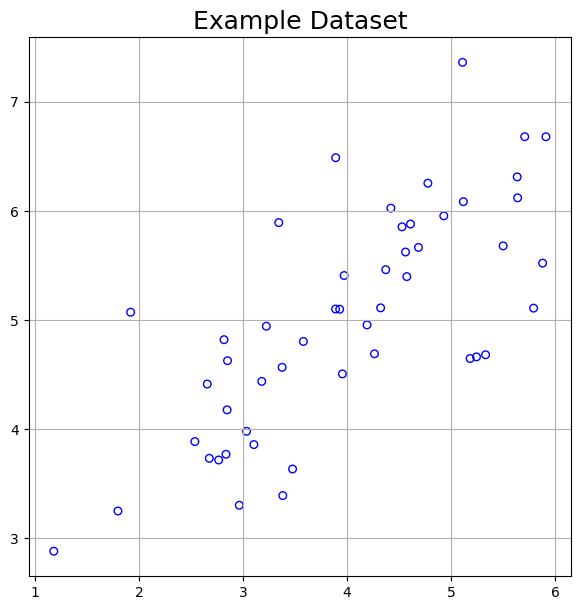

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.io

datafile = 'data/data1.mat'
mat = scipy.io.loadmat(datafile)
samples = mat['X']

plt.figure(figsize=(7, 7))
plt.scatter(samples[:, 0], samples[:, 1], s=30, facecolors='none', edgecolors='b')
plt.title("Example Dataset", fontsize=18)
plt.grid(True)
plt.show()

### 2.2 Implementing PCA \[20 pts\]

In this part of the exercise, you will implement PCA. PCA consists of
two computational steps: First, you compute the covariance matrix of the
data. Then, you use SVD (the scipy.linalg SVD function) to compute the
eigenvectors $U_1, U_2, \cdots , U_n$. These will correspond to the principal
components of variation in the data.

Before using PCA, it is important to first normalize the data. Normalize each feature by subtracting the mean value (to have zero mean), and scaling (to have unit variance) so that they are in the same range.

After normalizing the data, your task is to complete the code to compute the principal components of the dataset. First, you should compute the covariance matrix of the data, which is given by:

$$\Sigma = \frac{1}{m}X^T X$$

where $X$ is the data matrix with examples in rows, and $m$ is the number of examples. Note that here $\Sigma$ refers to a $n\times n$ matrix and not the summation operator. After computing the covariance matrix, you can run SVD on it to compute the principal components.

Once you have completed the code, the script below will run PCA on the example dataset and plot the corresponding principal components found. The script will also output the top principal component (eigenvector) found, which should be around \[-0.707 -0.707\].

In [ ]:
import scipy.linalg

def feature_normalize(samples):
    """
    Feature-normalize samples
    :param samples: samples.
    :return: normalized feature
    """
    raise NotImplementedError('Implement it yourself.')


def get_usv(sample_norm):
    # Compute the covariance matrix
    # Run single value decomposition to get the U principal component matrix
    raise NotImplementedError('Implement it yourself.')



Top principal component is  [-0.70710678 -0.70710678]


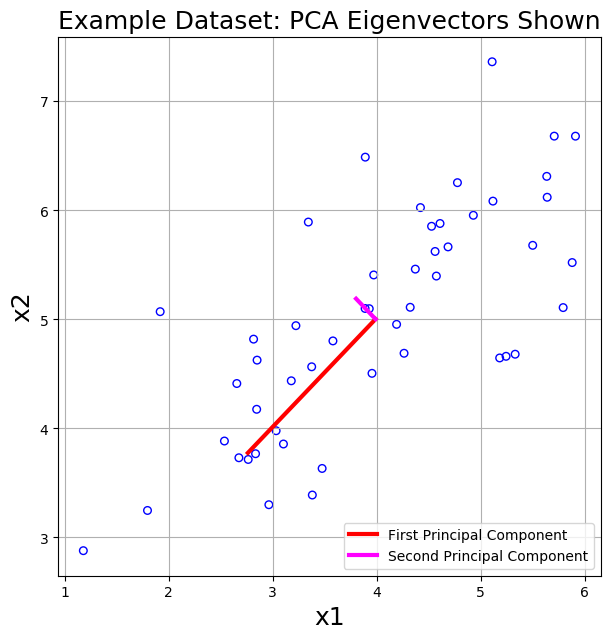

In [ ]:
# Feature normalize
means, stds, samples_norm = feature_normalize(samples)

# Run SVD
U, S, V = get_usv(samples_norm)

# output the top principal component (eigen- vector) found
# should expect to see an output of about [-0.707 -0.707]"
print('Top principal component is ', U[:, 0])

plt.figure(figsize=(7, 7))
plt.scatter(samples[:, 0], samples[:, 1], s=30, facecolors='none', edgecolors='b')
plt.title("Example Dataset: PCA Eigenvectors Shown", fontsize=18)
plt.xlabel('x1', fontsize=18)
plt.ylabel('x2', fontsize=18)
plt.grid(True)
# To draw the principal component, you draw them starting
# at the mean of the data
plt.plot([means[0], means[0] + S[0] * U[0, 0]],
        [means[1], means[1] + S[0] * U[1, 0]],
        color='red', linewidth=3,
        label='First Principal Component')
plt.plot([means[0], means[0] + S[1] * U[0, 1]],
        [means[1], means[1] + S[1] * U[1, 1]],
        color='fuchsia', linewidth=3,
        label='Second Principal Component')
plt.legend(loc=4)
plt.show()

### 2.3 Dimensionality Reduction with PCA

After computing the principal components, you can use them to reduce the feature dimension of your dataset by projecting each example onto a lower dimensional space, $x^i\rightarrow z^i$ (e.g., projecting the data from 2D to 1D).  In this part of the exercise, you will use the eigenvectors returned by PCA and project the example dataset into a 1-dimensional space.

In practice, if you were using a learning algorithm such as linear regression or perhaps neural networks, you could now use the projected data instead of the original data.  By using the projected data, you can train your model faster as there are fewer dimensions in the input.

**2.3.1 Projecting the data onto the principal components \[10 pts\]**

You should now complete the code in *project_data(samples, U, K)*. Specifically, you are
 given a dataset of samples, the principal components U, and the desired number
 of dimensions to reduce to K.  You should project each example in samples
 onto the top K components in U. Note that the top K components in U are
 given by the first K columns of U, that is $reduced\_U = U(:, 1:K)$.

Once you have completed the code, it will project the first example onto
    the first dimension and you should see a value of about 1.49 (or possibly
    -1.49, if you got -U1 instead of U1).

In [ ]:
def project_data(samples, U, K):
    """
    Computes the reduced data representation when
    projecting only on to the top "K" eigenvectors
    """
    # Reduced U is the first "K" columns in U
    raise NotImplementedError('Implement it yourself.')


# project the first example onto the first dimension
# should see a value of about 1.481"
z = project_data(samples_norm, U, 1)
print('Projection of the first example is %0.3f.' % float(z[0]))


Projection of the first example is 1.496.


**2.3.2 Reconstructing an approximation of the data \[10 pts\]**

After projecting the data onto the lower dimensional space, you can
    approximately recover the data by projecting them back onto the original
    high dimensional space.  Your task is to complete *recover_data(Z, U, K)* to project
    each example in Z back onto the original space and return the recovered
    approximation in *recovered\_sample*.

Once you have completed the code, it will recover an approximation of the
    first example and you should see a value of about [-1.05 -1.05].


In [ ]:
def recover_data(Z, U, K):
    raise NotImplementedError('Implement it yourself.')


# reconstruct the samples
recovered_sample = recover_data(z, U, 1)
print('Recovered approximation of the first example is ', recovered_sample[0])

Recovered approximation of the first example is  [-1.05805279 -1.05805279]


**2.3.3 Visualizing the projections \[10 pts\]**

After completing both *project\_data* and *recover\_data*, the script below should now
    perform both the projection and approximate reconstruction to show how the
    projection affects the data.  In the plot, the original
    data points are indicated with the blue circles, while the projected data
    points are indicated with the red circles.  The projection effectively only
    retains the information in the direction given by U1. If the plot looks correct, you get full points for this part.

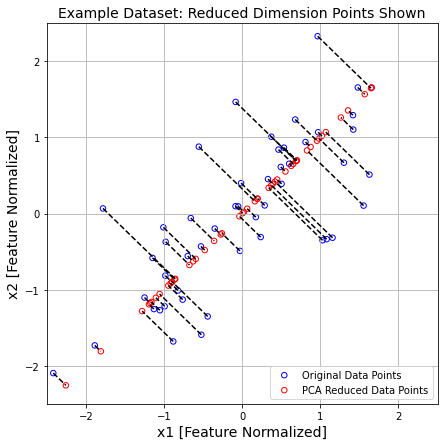

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(samples_norm[:, 0], samples_norm[:, 1], s=30, facecolors='none',
            edgecolors='b', label='Original Data Points')
plt.scatter(recovered_sample[:, 0], recovered_sample[:, 1], s=30, facecolors='none',
            edgecolors='r', label='PCA Reduced Data Points')

plt.title("Example Dataset: Reduced Dimension Points Shown", fontsize=14)
plt.xlabel('x1 [Feature Normalized]', fontsize=14)
plt.ylabel('x2 [Feature Normalized]', fontsize=14)
plt.grid(True)

for x in range(samples_norm.shape[0]):
    plt.plot([samples_norm[x, 0], recovered_sample[x, 0]], [samples_norm[x, 1], recovered_sample[x, 1]], 'k--')

plt.legend(loc=4)
plt.xlim((-2.5, 2.5))
plt.ylim((-2.5, 2.5))
plt.show()


### 2.4 Deriving PCA \[20 pts\]

Go through Section 12.1.2 which describes the Minimum-error formulation
of PCA and perform omitted computations. Specifically, do all the
derivations necessary to show that

0.  Before (12.9) $$\alpha_{nj} = \mathrm{x}_n^\mathrm{T}\mathrm{u}_j$$

1.  Eqn (12.12) $$z_{nj} = \mathrm{x}_n^\mathrm{T}\mathrm{u}_j$$

2.  Eqn (12.13) $$b_{j} = \overline{\mathrm{x}}^\mathrm{T}\mathrm{u}_j$$

3.  In case of two-dimensional data space
    $$\mathrm{S}\mathrm{u}_2 = \lambda_2\mathrm{u}_2$$ $$J = \lambda_2$$

[[insert solution here]]

### 2.5 [BONUS] Face Image Dataset \[20 pts\]

In this part of the exercise, you will run your PCA algorithm on
face images to see how it can be used in practice for dimension
reduction. The file *faces.mat* contains a dataset $X$ of face images,
each $32 \times 32$ in grayscale. Each row of $X$ corresponds to one face
image vectorized into a row vector of length 1024. The next step will
load and visualize the first 100 of these face images.

**2.5.0 Visualizing the data**

To display each row of $X$ as an image, we need to first reshape it into a 32x32 array. Implement the *get_datum_img* function below and run the visualization code.

In [ ]:
import pylab

def get_datum_img(row):
    """
    Creates an image from a single np array with shape 1x1024
    :param row: a single np array with shape 1x1024
    :return: the constructed image, np array of shape 32 x 32
    """
    raise NotImplementedError('Implement it yourself.')


def display_data(samples, num_rows=10, num_columns=10):
    """
    Function that picks the first 100 rows from X, creates an image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 32, 32
    num_rows, num_columns = num_rows, num_columns

    big_picture = np.zeros((height * num_rows, width * num_columns))

    row, column = 0, 0
    for index in range(num_rows * num_columns):
        if column == num_columns:
            row += 1
            column = 0
        img = get_datum_img(samples[index])
        big_picture[row * height:row * height + img.shape[0], column * width:column * width + img.shape[1]] = img
        column += 1
    plt.figure(figsize=(10, 10))
    plt.imshow(big_picture, cmap=pylab.gray())
    plt.show()

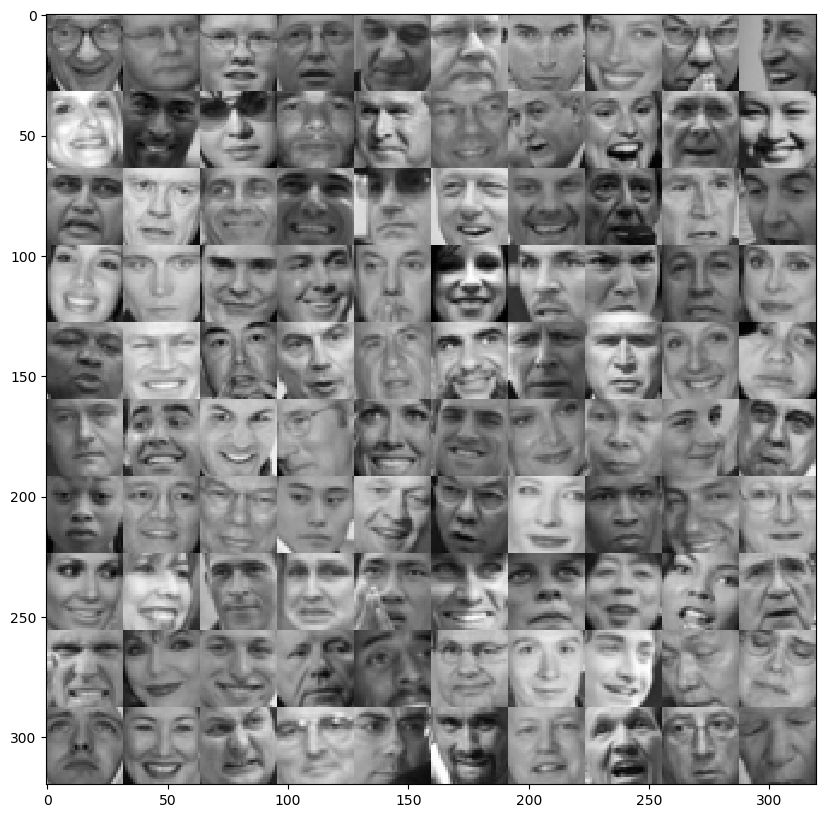

In [ ]:
datafile = 'data/faces.mat'
mat = scipy.io.loadmat(datafile)
samples = mat['X']
display_data(samples)

**2.5.1 PCA on Faces**

To run PCA on the face dataset, we first normalize the dataset by
normalizing each feature from the data matrix X to have zero mean and
unit variance.

After running PCA, you will obtain the principal components of the
dataset. Notice that each principal component in U (each row) is a
vector of length n (for the face dataset, n = 1024). It turns out that
we can visualize these principal components by reshaping each of them
into a $32
    \times 32$ matrix that corresponds to the pixels in the original
dataset. The code cell below displays the first 36 principal
components that describe the largest variations. If you
want, you can also change the code to display more principal components
to see how they capture more and more details.


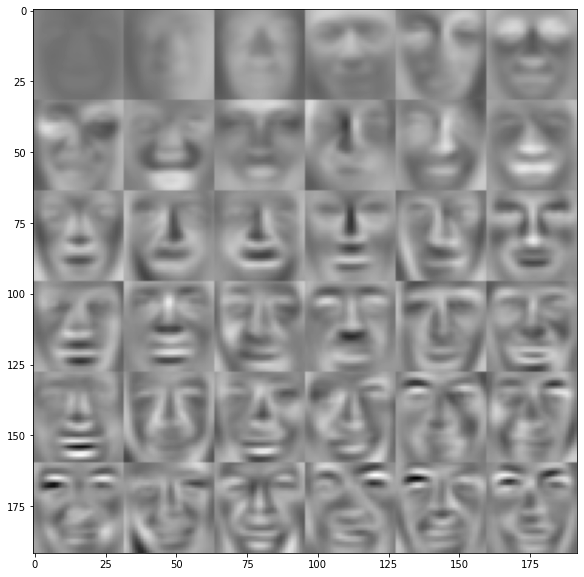

In [ ]:
# Feature normalize
raise NotImplementedError('Implement it yourself.')

# Run SVD
raise NotImplementedError('Implement it yourself.')

# Visualize the top 36 eigenvectors found
raise NotImplementedError('Implement it yourself.')


**2.5.2 Dimensionality Reduction**

Now that you have computed the principal components for the face
dataset, you can use it to perform dimensionality reduction. Reducing the dimensionality with PCA would allow you to use a learning algorithm with a smaller input size (e.g., 100 dimensions) instead of the original 1024 dimensions.

The next step will project the face dataset onto only
the first 100 principal components. Concretely, each face image is now
described by a vector $z_i\in \mathbb{R}^{100}$.

To understand what is lost in the dimension reduction, you can recover the data using only the projected dataset. In the code below, an approximate recovery of the data is performed and the projected face images are displayed. Comparing the reconstruction to the originals, you can observe that the general structure and appearance     of the face are retained while fine details are lost. This is a remarkable  reduction (more than 10$\times$) in the dataset size that can help speed up your learning algorithm significantly.  For example, if you were training a logistic regression model to perform face recognition (given a face image, predict the identity of the person), you can use the reduced input of only 100 dimensions instead of the original pixels.


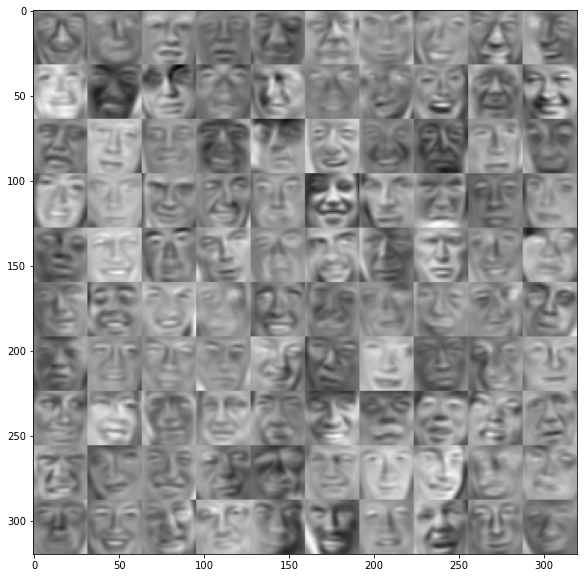

In [ ]:
# Project each image down to 100 dimensions
z = None  # complete this code

# Attempt to recover the original data
recovered_samples = None  #complete this code

# Plot the dimension-reduced data
display_data(recovered_samples)
plt.show()
